## GK2A

In [1]:
import os
from netCDF4 import Dataset
import numpy as np
from osgeo import gdal, osr
from pyproj import Transformer
import rasterio

C1 = 1.19104e-5  # in mW.(cm^-1)^-4.m^-2.sr^-1
C2 = 1.43877  # in K.cm

nu_c = 839.113  # in cm^-1


def get_gk2a_ir_bt(ipixel):
    gain = -0.0198196955025196 #IR105
    offset = 161.580139160156  #IR105
    c0 = -0.142866448475177
    c1 = 1.00064069572049
    c2 = -5.50443294960498e-07
    cval = 299792458.0 #1.3806488e-23
    kval =1.3806488e-23 #1.3806488e-23
    hval =  6.62606957e-34 #
    ir_wave =10.35
    wn = (10000 /ir_wave) * 100
    e1 = (2 * hval * cval * cval) * np.power(wn, 3)

    rad_slope =  0.9999575018882751
    rad_offset =  0.14451110363006592
 
    data = gain * ipixel + offset
    e2 = (data * 1e-5)
    t_eff = ((hval * cval / kval) * wn) / np.log((e1 / e2) + 1)
    bt_data = c0 + c1 * t_eff + c2 * t_eff * t_eff

    gsics_data = (bt_data - rad_offset) / rad_slope

    gsics_data = np.asarray(gsics_data)
    return gsics_data
    
nc_file = Dataset('gk2a_ami_le1b_ir105_fd020ge_202303210310.nc', 'a')

# Add global metadata
nc_file.setncattr('spatial_resolution', '2km at nadir')
nc_file.setncattr('project', 'GOES')

nc_file.close()

print("Metadata added successfully.")

# Define the origin and pixel size
origin_x, origin_y = -5505547.6175907375, 5505547.6175907375
pixel_width, pixel_height = 2002.017315487541055, -2002.017315487541055

# Convert netCDF to GeoTIFF
# 35785831
command_gk2a_1 = (
    'gdal_translate -ot float32 -a_srs "+proj=geos +lon_0=128.2 +h=35785831 +sweep=x +datum=WGS84" '
    '-unscale -co COMPRESS=NONE NETCDF:"./gk2a_ami_le1b_ir105_fd020ge_202303210310.nc":image_pixel_values gk2a_platecarree_new23.tif'
)
os.system(command_gk2a_1)

# Update the origin and pixel size using gdal_edit.py
command_gk2a_2 = (
    f'gdal_edit.py -a_ullr {origin_x} {origin_y} {origin_x + pixel_width * 5500} {origin_y + pixel_height * 5500} gk2a_platecarree_new23.tif'
)
os.system(command_gk2a_2)

print("GeoTIFF file has been successfully created with the specified origin and pixel size.")

command_gk2a_2 = 'gdalwarp -t_srs EPSG:4326 -dstnodata 32768 gk2a_platecarree_new23.tif gk2a_platecarree_new2333.tif'

os.system(command_gk2a_2)

tif_file = 'gk2a_platecarree_new2333.tif'
output_tif_file = 'gk2a_platecarree_new222223.tif'

with rasterio.open(tif_file) as src:
    data = src.read(1)
    processed_data = get_gk2a_ir_bt(data)
    processed_data = np.flipud(processed_data)

    meta = src.meta.copy()
    
    meta.update(dtype=rasterio.float32, nodata=np.nan)

    # Write the processed data to a new file
    with rasterio.open(output_tif_file, 'w', **meta) as dst:
        dst.write(processed_data.astype(rasterio.float32), 1)

print(f"Processed GeoTIFF file saved as {output_tif_file}")

ModuleNotFoundError: No module named 'netCDF4'

## Metsat

In [50]:
command_metsat_1 = 'gdal_translate -b 9 -ot float32 -unscale -CO COMPRESS=deflate "./MSG4-SEVI-MSG15-0100-NA-20230321031243.846000000Z-NA.nat" metsat_platecarree.tif'
command_metsat_2 = 'gdalwarp -t_srs EPSG:4326 -dstnodata -999.0 metsat_platecarree.tif metsat_platecarree_geo.tif'

os.system(command_metsat_1)
os.system(command_metsat_2)

Input file size is 3712, 3712
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing metsat_platecarree.tif [1/1] : 0Using internal nodata values (e.g. 0) for image metsat_platecarree.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


0

In [51]:
import numpy as np
import rasterio

# Constants
c = 299792458  # Speed of light in m/s
h = 6.62606957e-34  # Planck constant in J.s
k = 1.3806488e-23  # Boltzmann constant in J/K

C1 = 1.19104273e-5
C2 = 1.43877523

nu_c = 931.122  # in cm^-1
alpha = 0.9983
beta = 0.6256  # in K

gain = 0.2156
offset = -10.4

#slope = 0.03862197, off
#set = -1.96972038

def process_and_save(input_file, output_file):
    with rasterio.open(input_file) as src:
        data = src.read(1)  # Read the first band
        data = (data * gain + offset)
        data[data <= 0] = np.nan
        
        # Apply the conversion formula
        data = ((C2 * nu_c) / np.log((1.0 / data) * C1 * nu_c ** 3 + 1.0))
        data = (data - beta) / alpha
        
        # Update metadata
        meta = src.meta.copy()
        meta.update(dtype=rasterio.float32, nodata=np.nan)

        # Write the processed data to a new file
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(data.astype(rasterio.float32), 1)

    print(f"Processed GeoTIFF file saved as {output_file}")

# Process the individual files
input_files = ['metsat_platecarree_geo.tif']
processed_files = ['metsat_platecarree_geo_3.tif']

for input_file, output_file in zip(input_files, processed_files):
    process_and_save(input_file, output_file)


Processed GeoTIFF file saved as metsat_platecarree_geo_3.tif


## GEOS16

In [52]:
def get_geos16_ir_bt(rad):
    planck_fk1 = 10803.3
    planck_fk2 = 1392.74
    planck_bc1 = 0.0755
    planck_bc2 = 0.99975    
    BT = ((planck_fk2 / (np.log((planck_fk1 / rad) + 1))) - planck_bc1) / planck_bc2
    gsics_data = np.asarray(BT)
    return gsics_data

def get_geos18_ir_bt(rad):
    planck_fk1 = 10818.4
    planck_fk2 = 1393.39
    planck_bc1 = 0.07725
    planck_bc2 = 0.99974    
    BT = ((planck_fk2 / (np.log((planck_fk1 / rad) + 1))) - planck_bc1) / planck_bc2
    gsics_data = np.asarray(BT)
    return gsics_data

command_g18_1 = 'gdal_translate -ot float32 -unscale -CO COMPRESS=deflate NETCDF:"./OR_ABI-L1b-RadF-M6C13_G18_s20230800310204_e20230800319525_c20230800319562.nc":Rad geos18_platecarree.tif'
command_g18_2 = 'gdalwarp -t_srs EPSG:4326 -dstnodata -999.0 geos18_platecarree.tif geos18_platecarree_geo.tif'

os.system(command_g18_1)
os.system(command_g18_2)

Input file size is 5424, 5424
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing geos18_platecarree.tif [1/1] : 0

ERROR 1: Too many points (529 out of 529) failed to transform, unable to compute output bounds.
Warning 1: Unable to compute source region for output window 3530,0,1765,2997, skipping.


Using internal nodata values (e.g. 4095) for image geos18_platecarree.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


0

In [53]:
tif_file = 'geos18_platecarree_geo.tif'
output_tif_file = 'processed_geos18_platecarree_geo10.tif'

with rasterio.open(tif_file) as src:
    data = src.read(1)
    processed_data = get_geos18_ir_bt(data)
    processed_data[processed_data < 0] = np.nan
    meta = src.meta.copy()
    
    meta.update(dtype=rasterio.float32, nodata= np.nan)

    # Write the processed data to a new file
    with rasterio.open(output_tif_file, 'w', **meta) as dst:
        dst.write(processed_data.astype(rasterio.float32), 1)

print(f"Processed GeoTIFF file saved as {output_tif_file}")

Processed GeoTIFF file saved as processed_geos18_platecarree_geo10.tif


/tmp/ipykernel_2709/2863605524.py:15: RuntimeWarning: invalid value encountered in log
  BT = ((planck_fk2 / (np.log((planck_fk1 / rad) + 1))) - planck_bc1) / planck_bc2


## MERGE

In [54]:
import os
import subprocess
import rasterio
import numpy as np

# Define the input files and nodata value
input_files = ['gk2a_platecarree_new222223.tif', 'metsat_platecarree_geo_3.tif', 'processed_geos18_platecarree_geo10.tif']

merge_command = f'gdal_merge.py -ps 0.018 0.018 -o pray_pray14.tif ' + ' '.join(input_files)
subprocess.run(merge_command, shell=True)

print("Files have been successfully merged into abaa.tif")

0...10...20...30...40...50...60...70...80...90...100 - done.
Files have been successfully merged into abaa.tif


In [55]:
import os
import subprocess
import rasterio
import numpy as np

# Define the input files and nodata value
input_files = ['metsat_platecarree_geo_3.tif', 'processed_geos18_platecarree_geo10.tif', 'gk2a_platecarree_new222223.tif']

merge_command = f'gdal_merge.py -ps 0.018 0.018 -o pray_pray15.tif ' + ' '.join(input_files)
subprocess.run(merge_command, shell=True)

print("Files have been successfully merged into abaa.tif")


0...10...20...30...40...50...60...70...80...90...100 - done.
Files have been successfully merged into abaa.tif


In [60]:
output_tif_file = 'final.tif'
tif_file = 'pray_pray15.tif'

with rasterio.open(tif_file) as src:
    data1 = src.read(1)

tif_file = 'pray_pray14.tif'

with rasterio.open(tif_file) as src:
    data2 = src.read(1)
    data2[:, -2500:] = data1[:,-2500:]
    meta = src.meta.copy()
    
    meta.update(dtype=rasterio.float32, nodata=np.nan)

    # Write the processed data to a new file
    with rasterio.open(output_tif_file, 'w', **meta) as dst:
        dst.write(data2.astype(rasterio.float32), 1)

In [61]:
output_tif_file = 'final.tif'
tif_file = 'pray_pray15.tif'

with rasterio.open(tif_file) as src:
    data1 = src.read(1)

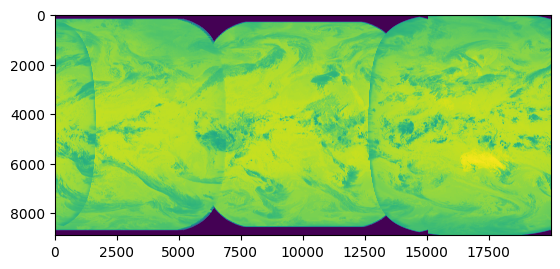

In [63]:
plt.imshow(data1)

In [65]:
import os
import subprocess
import rasterio
import numpy as np

# Define the input files and nodata value
input_files = ['processed_geos18_platecarree_geo10.tif', 'gk2a_platecarree_new222223.tif', 'metsat_platecarree_geo_3.tif']

merge_command = f'gdal_merge.py -ps 0.018 0.018 -o pray_pray17.tif ' + ' '.join(input_files)
subprocess.run(merge_command, shell=True)

print("Files have been successfully merged into abaa.tif")


0...10...20...30...40...50...60...70...80...90...100 - done.
Files have been successfully merged into abaa.tif


In [66]:
output_tif_file = 'final.tif'
tif_file = 'pray_pray17.tif'

with rasterio.open(tif_file) as src:
    data1 = src.read(1)

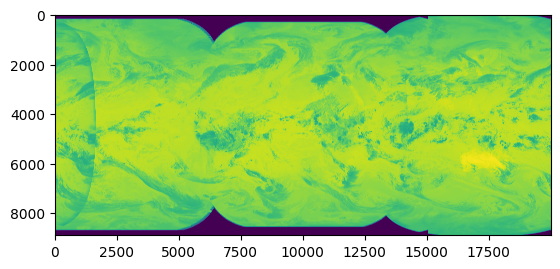

In [67]:
plt.imshow(data1)